<a href="https://colab.research.google.com/github/JiwonHae94/Tensorflow-For-Beginners/blob/main/Tensorflow_ImageClassification_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# dogs and cats dataset
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   141M      0  0:00:05  0:00:05 --:--:--  155M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages/

Cat  Dog


In [5]:
import os

num_skipped = 0

for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      
      #Delete corrupted images
      os.remove(fpath)
print(f"Deleted {num_skipped} images")

Deleted 1590 images


In [6]:
# Generate a Dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


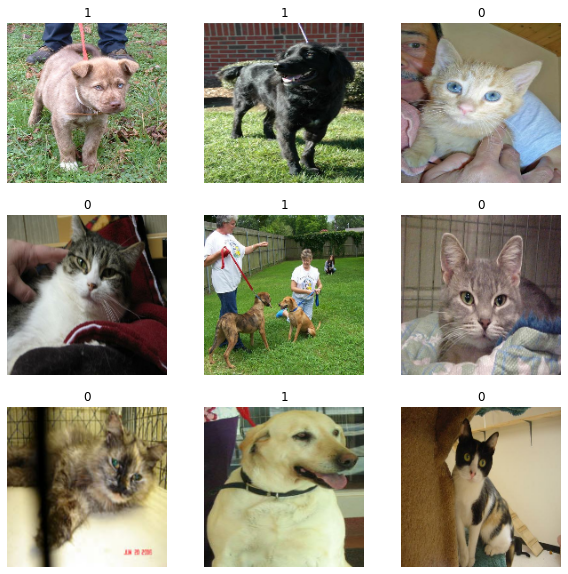

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [8]:
# data augmentation
data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
])

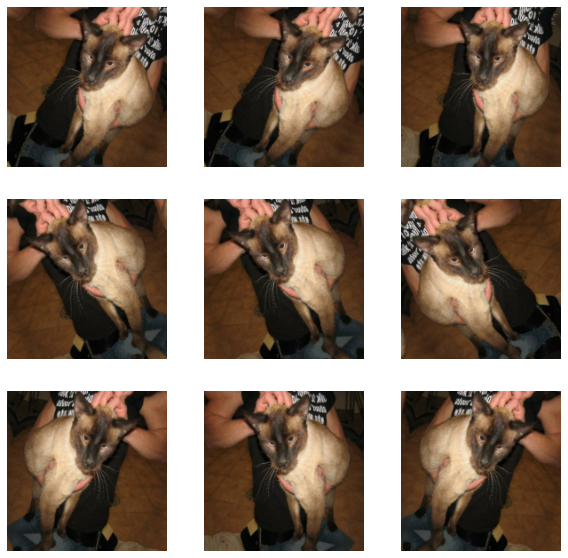

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
# Standardizing the data -> Normalization
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
)

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

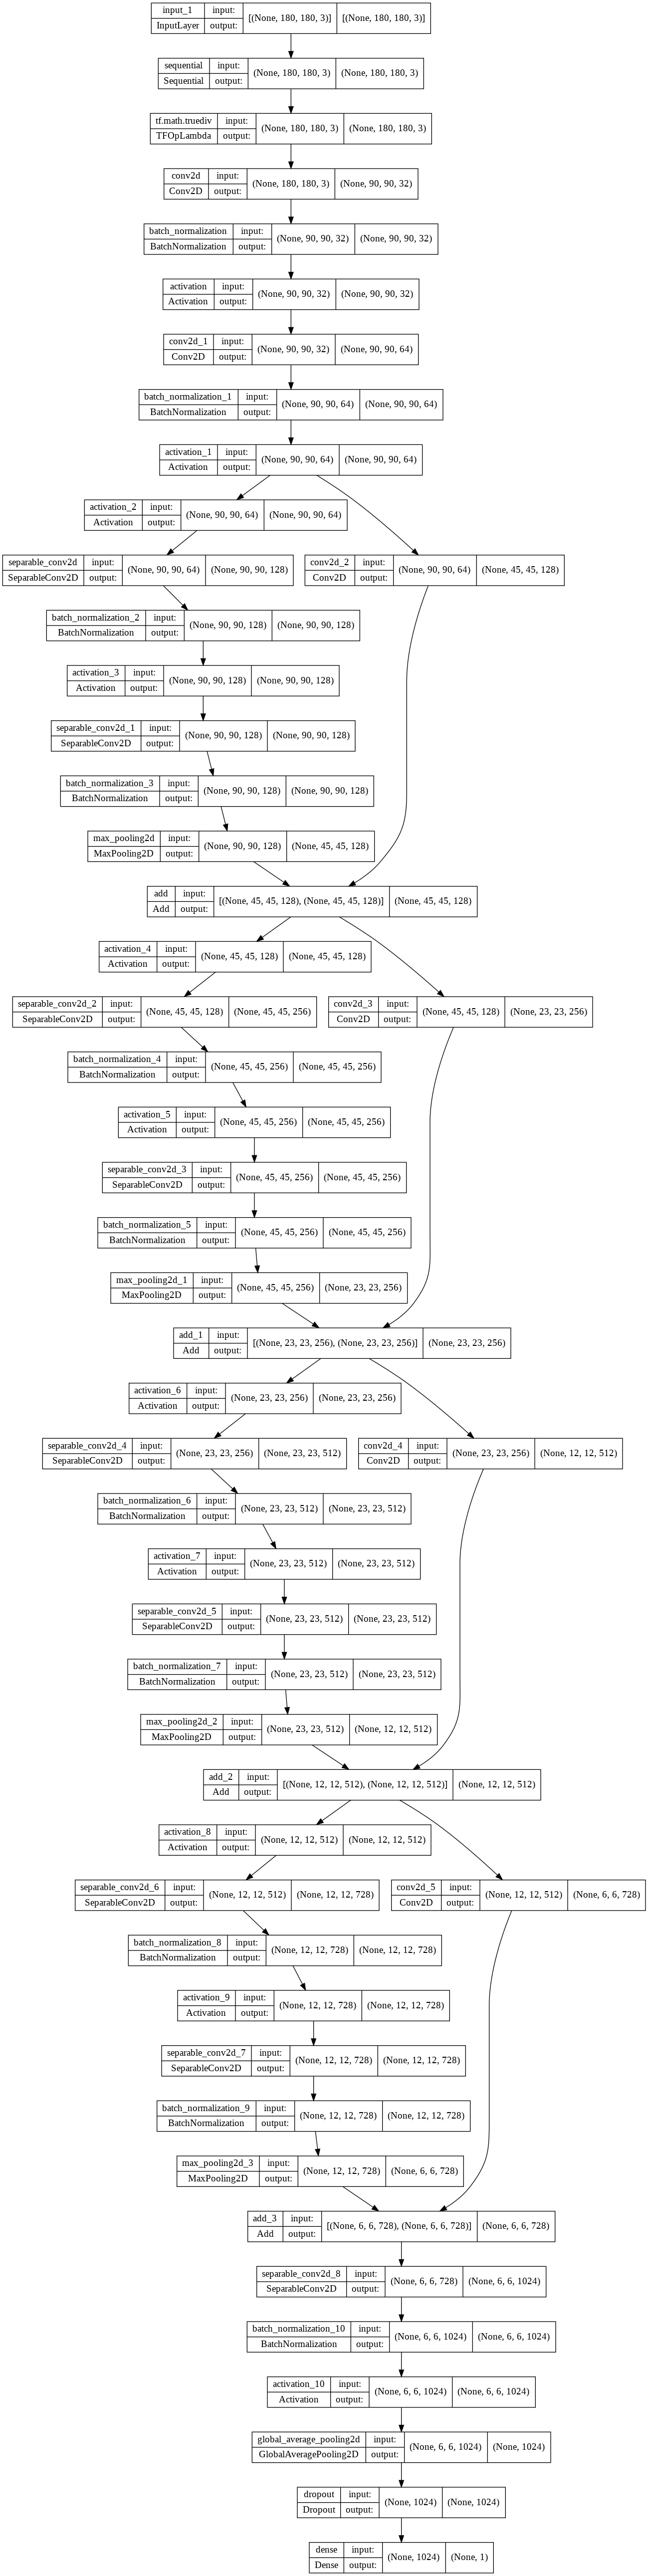

In [12]:
# make a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x /= 255.0
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes = True)


In [18]:
# train
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs = epochs, callbacks = callbacks, validation_data = val_ds
)

Epoch 1/50
586/586 [==============================] - 298s 483ms/step - loss: 0.6348 - accuracy: 0.6601 - val_loss: 0.6447 - val_accuracy: 0.6258
Epoch 2/50
586/586 [==============================] - 282s 480ms/step - loss: 0.4800 - accuracy: 0.7740 - val_loss: 0.4364 - val_accuracy: 0.8069
Epoch 3/50
586/586 [==============================] - 281s 479ms/step - loss: 0.3972 - accuracy: 0.8195 - val_loss: 0.4245 - val_accuracy: 0.8080
Epoch 4/50
586/586 [==============================] - 282s 480ms/step - loss: 0.3232 - accuracy: 0.8590 - val_loss: 0.3350 - val_accuracy: 0.8537
Epoch 5/50
586/586 [==============================] - 281s 480ms/step - loss: 0.2660 - accuracy: 0.8871 - val_loss: 0.2508 - val_accuracy: 0.8979
Epoch 6/50
586/586 [==============================] - 282s 480ms/step - loss: 0.2297 - accuracy: 0.9030 - val_loss: 0.2270 - val_accuracy: 0.9062
Epoch 7/50
586/586 [==============================] - 282s 480ms/step - loss: 0.2048 - accuracy: 0.9166 - val_loss: 0.3854 -

In [20]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size = image_size
)


img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.33 percent cat and 0.67 percent dog.
